In [0]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

In [0]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import ast


# We are also going to do some basic viz
import matplotlib.pyplot as plt
%matplotlib inline 



connection_args = {
    'host': '52.42.179.214',  # We are connecting to our _local_ version of psql
    'user': 'ubuntu',
    'dbname': 'crime',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)

In [0]:
# The data was too big to load from AWS database as a view so I used google colab to
# get it and then saved by batches
crime_1 = pd.read_csv('Final_crime_100000.csv')
crime_2 = pd.read_csv('Final_crime_200000.csv')
crime_3 = pd.read_csv('Final_crime_300000.csv')
crime_4 = pd.read_csv('Final_crime_400000.csv')
crime_5 = pd.read_csv('Final_crime_500000.csv')
crime_6 = pd.read_csv('Final_crime_600000.csv')
crime_7 = pd.read_csv('Final_crime_700000.csv')
crime_8 = pd.read_csv('Final_crime_800000.csv')
crime_9 = pd.read_csv('Final_crime_900000.csv')
crime_10 = pd.read_csv('Final_crime_1000000.csv')
crime_11 = pd.read_csv('Final_crime_1100000.csv')
crime_12 = pd.read_csv('Final_crime_1200000.csv')
crime_13 = pd.read_csv('Final_crime_1300000.csv')


In [0]:
crime_wo_victim_df = pd.concat([crime_1,crime_2,crime_3,crime_4,crime_5,crime_6,crime_7,crime_8,crime_9,crime_10,crime_11,crime_12,crime_13], ignore_index = True)

In [15]:
crime_wo_victim_df.describe()

DR Number       Area ID  ...     Owner_occ    Renter_occ
count  1.260625e+06  1.260625e+06  ...  1.260624e+06  1.260624e+06
mean   1.476740e+08  1.111343e+01  ...  3.340553e+04  5.524525e+04
std    1.737107e+07  6.012429e+00  ...  1.304023e+04  1.732788e+04
min    2.100000e+02  1.000000e+00  ...  1.363856e+04  2.603106e+04
25%    1.314188e+08  6.000000e+00  ...  2.621229e+04  4.415894e+04
50%    1.506068e+08  1.200000e+01  ...  3.166819e+04  5.299337e+04
75%    1.615057e+08  1.600000e+01  ...  4.220131e+04  6.710609e+04
max    1.921118e+08  2.100000e+01  ...  6.027421e+04  8.126827e+04

[8 rows x 38 columns]

In [0]:
# putting the victim information in as well
query = 'SELECT "DR Number", "Victim Age", "Victim Descent" FROM new_clean_crime;'

victim_df = pd_sql.read_sql(query, connection)


In [17]:

victim_df.describe()

DR Number    Victim Age
count  1.257777e+06  1.257777e+06
mean   1.476558e+08  3.196252e+01
std    1.737359e+07  2.064092e+01
min    2.100000e+02 -7.000000e+00
25%    1.314174e+08  2.000000e+01
50%    1.506046e+08  3.200000e+01
75%    1.615054e+08  4.700000e+01
max    1.921118e+08  1.140000e+02

# New Section

In [18]:
crime_wo_victim_df.shape

(1260625, 44)

In [0]:
crime_df = pd.merge(crime_wo_victim_df,victim_df, on = 'DR Number')

In [20]:
crime_df.describe()

DR Number       Area ID  ...    Renter_occ    Victim Age
count  1.260625e+06  1.260625e+06  ...  1.260624e+06  1.260625e+06
mean   1.476740e+08  1.111343e+01  ...  5.524525e+04  3.196222e+01
std    1.737107e+07  6.012429e+00  ...  1.732788e+04  2.064097e+01
min    2.100000e+02  1.000000e+00  ...  2.603106e+04 -7.000000e+00
25%    1.314188e+08  6.000000e+00  ...  4.415894e+04  2.000000e+01
50%    1.506068e+08  1.200000e+01  ...  5.299337e+04  3.200000e+01
75%    1.615057e+08  1.600000e+01  ...  6.710609e+04  4.700000e+01
max    1.921118e+08  2.100000e+01  ...  8.126827e+04  1.140000e+02

[8 rows x 39 columns]

In [21]:
crime_df.head()

DR Number        Date Reported  ... Victim Age  Victim Descent
0  151721163  2015-12-28 00:00:00  ...          0            None
1  151801014  2015-07-14 00:00:00  ...         36               H
2  151804054  2015-01-01 00:00:00  ...         72               B
3  151804184  2015-01-05 00:00:00  ...         57               H
4  151804423  2015-01-09 00:00:00  ...         32               H

[5 rows x 46 columns]

In [22]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260625 entries, 0 to 1260624
Data columns (total 46 columns):
DR Number                  1260625 non-null int64
Date Reported              1260625 non-null object
Date Occurred              1260625 non-null object
Area ID                    1260625 non-null int64
Area Name                  1260625 non-null object
Reporting District         1260625 non-null int64
Crime Code                 1260625 non-null int64
Crime Code Description     1260625 non-null object
Premise Code               1260601 non-null float64
Premise Description        1260598 non-null object
Weapon Used Code           414780 non-null float64
Latitude                   1260625 non-null float64
Longitude                  1260625 non-null float64
Hour_Occurred              1260625 non-null float64
Time_Occurred_with_hour    1260625 non-null object
target_arrested            1260625 non-null float64
Year_of_Occurred           1260625 non-null float64
Year_of_Reported  

In [0]:
# there are some negative victim ages, we will get rid of those
crime_df = crime_df[crime_df['Victim Age']>0]

In [24]:
crime_df.shape

(1042759, 46)

In [0]:
# we consider the years 2012-2017 since we have weather data from
# those years
crime_dff = crime_df[crime_df['Year_of_Reported'] < 2018]

In [26]:
crime_dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034762 entries, 1 to 1260624
Data columns (total 46 columns):
DR Number                  1034762 non-null int64
Date Reported              1034762 non-null object
Date Occurred              1034762 non-null object
Area ID                    1034762 non-null int64
Area Name                  1034762 non-null object
Reporting District         1034762 non-null int64
Crime Code                 1034762 non-null int64
Crime Code Description     1034762 non-null object
Premise Code               1034751 non-null float64
Premise Description        1034748 non-null object
Weapon Used Code           392946 non-null float64
Latitude                   1034762 non-null float64
Longitude                  1034762 non-null float64
Hour_Occurred              1034762 non-null float64
Time_Occurred_with_hour    1034762 non-null object
target_arrested            1034762 non-null float64
Year_of_Occurred           1034762 non-null float64
Year_of_Reported  

In [27]:
crime_dff.describe()

DR Number       Area ID  ...    Renter_occ    Victim Age
count  1.034762e+06  1.034762e+06  ...  1.034761e+06  1.034762e+06
mean   1.471998e+08  1.108123e+01  ...  5.536108e+04  3.865453e+01
std    1.714041e+07  6.074176e+00  ...  1.731623e+04  1.600453e+01
min    1.208575e+06  1.000000e+00  ...  2.603106e+04  2.000000e+00
25%    1.313223e+08  6.000000e+00  ...  4.415894e+04  2.600000e+01
50%    1.504131e+08  1.100000e+01  ...  5.299337e+04  3.600000e+01
75%    1.613244e+08  1.600000e+01  ...  6.710609e+04  5.000000e+01
max    1.915109e+08  2.100000e+01  ...  8.126827e+04  1.140000e+02

[8 rows x 39 columns]

In [0]:
# visualize the victim age distribution
victim_over_crime = crime_dff[['Victim Age','DR Number']].groupby(['Victim Age']).count().reset_index()

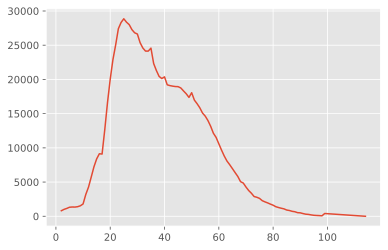

In [29]:
plt.plot(victim_over_crime['Victim Age'],victim_over_crime['DR Number'])

Looks like mid 20's is the age that are victims of crime

Crimes fall under the following categories:
* Violent Crimes
* * Homicide
* * Rape
* * Robbery
* * Aggrevated Assualt
* * Simple Assault


* Property Crimes
* * Burgalry
* * MVT (GTA)
* * BTFV
* * Personal Theft
* * Other Theft

Thus instead of having 138 different categories, we will divide the crimes into the above 10 categories

There were some crime codes that didn't fall under the above categories so we will put them under 'Other'

In [30]:
crime_dff['Crime_Code_Name'] = crime_dff['Crime Code'].map({110: 'Homocide', 113: 'Homocide', 
                                                          121: 'Rape', 122: 'Rape', 815: 'Rape', 820:'Rape', 821:'Rape', 
                                                          210:'Robbery', 220:'Robbery', 
                                                          230:'Agg.Assault',231:'Agg.Assault',235:'Agg.Assault',
                                                          236:'Agg.Assault',250:'Agg.Assault',251:'Agg.Assault',
                                                          761:'Agg.Assault',929:'Agg.Assault',237:'Agg.Assault',
                                                          435:'SimpleAssault',436:'SimpleAssault',437:'SimpleAssault',
                                                          622:'SimpleAssault',623:'SimpleAssault',624:'SimpleAssault',
                                                          625:'SimpleAssault',626:'SimpleAssault',627:'SimpleAssault',
                                                          647:'SimpleAssault',763:'SimpleAssault',928:'SimpleAssault',
                                                          930:'SimpleAssault',745:'SimpleAssault',
                                                          310:'Burglary',320:'Burglary',
                                                          510:'MTV(GTA)',520:'MTV(GTA)',433:'MTV(GTA)',
                                                          330:'BTFV',331:'BTFV',410:'BTFV',420:'BTFV',421:'BTFV',
                                                            350:'Personal_Theft',351:'Personal_Theft',352:'Personal_Theft',
                                                            353:'Personal_Theft',450:'Personal_Theft',451:'Personal_Theft',
                                                            452:'Personal_Theft',453:'Personal_Theft',
                                                            341:'Other_Theft',341:'Other_Theft',343:'Other_Theft',
                                                            347:'Other_Theft',349:'Other_Theft',354:'Other_Theft',
                                                            345:'Other_Theft',440:'Other_Theft',441:'Other_Theft',
                                                            442:'Other_Theft',443:'Other_Theft',444:'Other_Theft',
                                                            445:'Other_Theft',470:'Other_Theft',471:'Other_Theft',
                                                            472:'Other_Theft',473:'Other_Theft',474:'Other_Theft',
                                                            475:'Other_Theft',480:'Other_Theft',485:'Other_Theft',
                                                            487:'Other_Theft',491:'Other_Theft',
                                                            432:'Other',434:'Other',438:'Other',439:'Other',446:'Other',
                                                             648:'Other',649:'Other', 651:'Other',652:'Other',
                                                             653:'Other',654:'Other',660:'Other', 661:'Other',662:'Other',
                                                             664:'Other',666:'Other',668:'Other',670:'Other',740:'Other',
                                                             753:'Other',755:'Other',756:'Other',760:'Other',762:'Other',
                                                             805:'Other',806:'Other',810:'Other',812:'Other',813:'Other',
                                                             814:'Other',822:'Other',830:'Other', 840:'Other',850:'Other',
                                                             860:'Other',865:'Other',870:'Other', 880:'Other',882:'Other',
                                                             884:'Other',886:'Other',888:'Other',890:'Other',900:'Other',
                                                             901:'Other', 902:'Other', 903:'Other',906:'Other',910:'Other',
                                                             920:'Other',921:'Other', 922:'Other', 924:'Other',926:'Other',
                                                             931:'Other',932:'Other',933:'Other', 940:'Other',942:'Other',
                                                             943:'Other', 944:'Other',946:'Other',948:'Other',949:'Other',
                                                             950:'Other', 951:'Other',952:'Other',954:'Other',956:'Other'})


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
crime_dff.columns

Index(['DR Number', 'Date Reported', 'Date Occurred', 'Area ID', 'Area Name',
       'Reporting District', 'Crime Code', 'Crime Code Description',
       'Premise Code', 'Premise Description', 'Weapon Used Code', 'Latitude',
       'Longitude', 'Hour_Occurred', 'Time_Occurred_with_hour',
       'target_arrested', 'Year_of_Occurred', 'Year_of_Reported',
       'Month_of_Occurred', 'Month_of_Reported', 'Day_of_Occurred',
       'Day_of_Reported', 'day_of_week_of_occurred', 'day_of_week_of_reported',
       'LA_temp', 'council_code_integer', 'Pop2010', 'White_pop', 'Black_pop',
       'Ameri_es_pop', 'Asian_pop', 'Hawn_pi_pop', 'Hispanic_pop', 'Other_pop',
       'Multi_pop', 'Male_pop', 'Female_pop', 'Median_age', 'Med_age_male',
       'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 'Renter_occ',
       'Victim Age', 'Victim Descent', 'Crime_Code_Name'],
      dtype='object')

In [0]:
# removing some of the demographics columns
crime_df_less_columns = crime_dff[['DR Number','Date Reported','Area ID','Crime_Code_Name','Latitude',
       'Longitude', 'Hour_Occurred', 'Time_Occurred_with_hour',
       'Year_of_Reported','Month_of_Reported', 
       'Day_of_Reported', 'day_of_week_of_reported','LA_temp','Pop2010', 'White_pop', 'Black_pop',
       'Ameri_es_pop', 'Asian_pop', 'Hawn_pi_pop', 'Hispanic_pop', 'Other_pop',
       'Multi_pop', 'Male_pop', 'Female_pop', 'Median_age', 'Med_age_male',
       'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 'Renter_occ','Victim Age','target_arrested']]

In [99]:
crime_df_less_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034762 entries, 1 to 1260624
Data columns (total 33 columns):
DR Number                  1034762 non-null int64
Date Reported              1034762 non-null object
Area ID                    1034762 non-null int64
Crime_Code_Name            1034762 non-null object
Latitude                   1034762 non-null float64
Longitude                  1034762 non-null float64
Hour_Occurred              1034762 non-null float64
Time_Occurred_with_hour    1034762 non-null object
Year_of_Reported           1034762 non-null float64
Month_of_Reported          1034762 non-null float64
Day_of_Reported            1034762 non-null float64
day_of_week_of_reported    1034762 non-null float64
LA_temp                    892788 non-null float64
Pop2010                    1034762 non-null float64
White_pop                  1034762 non-null float64
Black_pop                  1034762 non-null float64
Ameri_es_pop               1034762 non-null float64
Asian_pop  

In [0]:
# there is target equal to 4, we will delete that
crime_df_less_columns = crime_df_less_columns[crime_df_less_columns.target_arrested != 4]

target_count = crime_df_less_columns.target_arrested.value_counts()

In [101]:
target_count.head()

0.0    911972
1.0    122789
Name: target_arrested, dtype: int64

In [102]:
# print class balance
target_count = crime_df_less_columns.target_arrested.value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 911972
Class 1: 122789
Proportion: 7.43 : 1
Percentage of Majority Class: 88.13


Class 0: 911972
Class 1: 122789
Proportion: 7.43 : 1
Percentage of Majority Class: 88.13


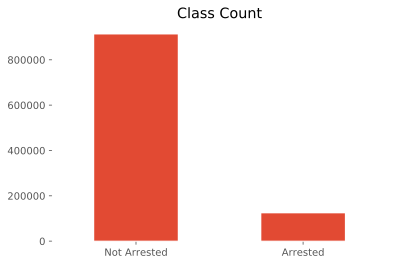

In [103]:
target_count = crime_df_less_columns.target_arrested.value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
# Specify facecolor when creating the figure
fig, ax = plt.subplots(facecolor='white')
target_count.plot(kind='bar', title='Class Count', rot=0, ax=ax)
# Specify background color for the axis/plot
ax.set_facecolor("white")
plt.xticks(np.arange(2), ('Not Arrested', 'Arrested'))
plt.savefig('unbalanced.jpg')


As we can see we have highly unbalanced dataset, about 88% of the crimes have not resulted in arrests for various reasons


In [0]:
grouped_year_month_day_df = crime_df_less_columns[['Date Reported', 'target_arrested']].groupby(['Date Reported']).count().reset_index()

In [105]:
grouped_year_month_day_df.head()

Date Reported  target_arrested
0  2012-01-01 00:00:00              271
1  2012-01-02 00:00:00              310
2  2012-01-03 00:00:00              325
3  2012-01-04 00:00:00              381
4  2012-01-05 00:00:00              343

In [111]:
plt.figure(figsize=(20,5))
plt.plot(grouped_year_month_day_df['Date Reported'], grouped_year_month_day_df.target_arrested)

There is a seasonal pattern to the crimes, during summer months crime count is higher and during winter it is low.

There is also increase of crime each year, which could be due to population increase

In [0]:
grouped_area_df = crime_df_less_columns[['Area ID', 'target_arrested']].groupby(['Area ID']).count().reset_index()

In [118]:
grouped_area_df

Area ID  target_arrested
0         1            50565
1         2            45469
2         3            71443
3         4            33976
4         5            41858
5         6            46781
6         7            42630
7         8            46039
8         9            49834
9        10            43228
10       11            47326
11       12            74291
12       13            44463
13       14            52362
14       15            55339
15       16            37662
16       17            46564
17       18            55635
18       19            50509
19       20            45851
20       21            52936

<BarContainer object of 21 artists>

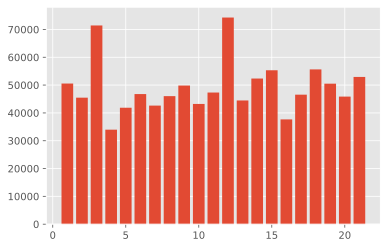

In [119]:
plt.bar(grouped_area_df['Area ID'], grouped_area_df['target_arrested'])

Area 3 an 12 have the higest crimes. Thouse are 77th street and Southwest

## Baseline Models

In [120]:
crime_df_less_columns = crime_df_less_columns.drop('Date Reported', axis = 1)
crime_df_less_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034761 entries, 1 to 1260624
Data columns (total 32 columns):
DR Number                  1034761 non-null int64
Area ID                    1034761 non-null int64
Crime_Code_Name            1034761 non-null object
Latitude                   1034761 non-null float64
Longitude                  1034761 non-null float64
Hour_Occurred              1034761 non-null float64
Time_Occurred_with_hour    1034761 non-null object
Year_of_Reported           1034761 non-null float64
Month_of_Reported          1034761 non-null float64
Day_of_Reported            1034761 non-null float64
day_of_week_of_reported    1034761 non-null float64
LA_temp                    892787 non-null float64
Pop2010                    1034761 non-null float64
White_pop                  1034761 non-null float64
Black_pop                  1034761 non-null float64
Ameri_es_pop               1034761 non-null float64
Asian_pop                  1034761 non-null float64
Hawn_pi_po

In [0]:
# make the 'Area ID' and 'Crime_Code_Name' into dummy variables
crime_df_less_columns[['Crime_Code_Name_AggAssault','Crime_Code_Name_BTFV','Crime_Code_Name_Burglary','Crime_Code_Name_Homocide','Crime_Code_Name_MTV(GTA)','Crime_Code_Name_Other_Theft','Crime_Code_Name_Personal_Theft','Crime_Code_Name_Rape','Crime_Code_Name_Robbery','Crime_Code_Name_SimpleAssault']] = pd.get_dummies(crime_df_less_columns[['Crime_Code_Name']]).drop(['Crime_Code_Name_Other'], axis = 1)


In [0]:
crime_df_less_columns[['Area ID_10','Area ID_11','Area ID_12','Area ID_13','Area ID_14','Area ID_15','Area ID_16','Area ID_17','Area ID_18','Area ID_19','Area ID_2','Area ID_20','Area ID_21','Area ID_3','Area ID_4','Area ID_5','Area ID_6','Area ID_7','Area ID_8','Area ID_9']] = pd.get_dummies(crime_df_less_columns[['Area ID']].astype(str), drop_first = True)


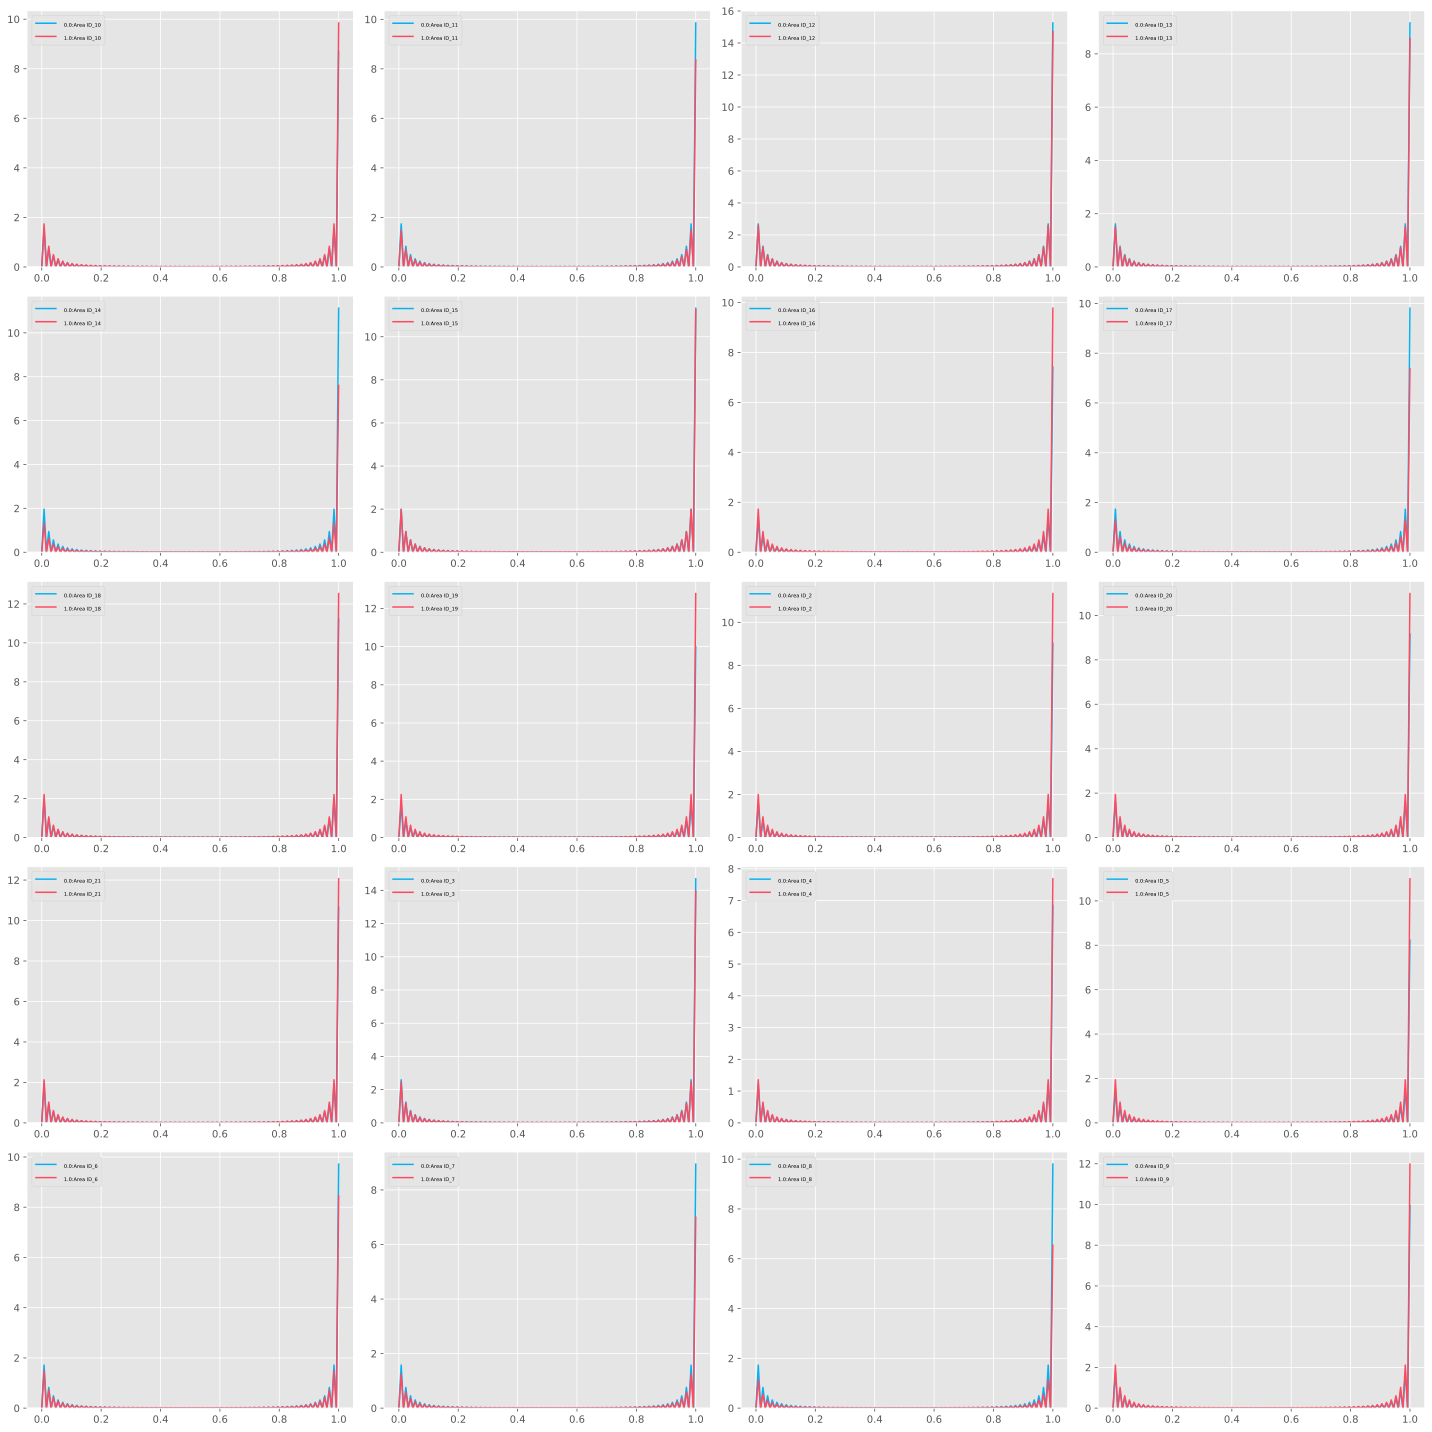

In [123]:
# Distribution of some of the features
features = crime_df_less_columns[['Area ID_10', 'Area ID_11', 'Area ID_12', 'Area ID_13', 'Area ID_14',
       'Area ID_15', 'Area ID_16', 'Area ID_17', 'Area ID_18', 'Area ID_19',
       'Area ID_2', 'Area ID_20', 'Area ID_21', 'Area ID_3', 'Area ID_4',
       'Area ID_5', 'Area ID_6', 'Area ID_7', 'Area ID_8', 'Area ID_9', 'Crime_Code_Name_SimpleAssault', 'target_arrested']]

grouped_features = features.groupby('target_arrested')

features.columns

#sns.set(font_scale=1.8)
sns.set_palette(['#06B1F0', '#FC4B60'])
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), features.columns):
    for k, v in grouped_features[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)
        plt.setp(ax.get_legend().get_texts(), fontsize='5')
plt.savefig('feature_distributions.png')

In [0]:
def vl_mean(row):
  '''This fn is used to replace the missing temperature 
  vaalues in the test set by the mean of temo of the train set'''
  if str(row['LA_temp']) == 'nan':
    return monthly_temp[row['Month_of_Reported']]
  else: 
    return row['LA_temp']


In [0]:
# Baseline Model
X = crime_df_less_columns.drop(['Crime_Code_Name','DR Number','target_arrested','Time_Occurred_with_hour'], axis = 1)
y = crime_df_less_columns['target_arrested']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 2, stratify = y, shuffle = True)

In [0]:
# in logistic regression need to scale the continuous variables
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

ave = X_train_scaled[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].transform('mean')
monthly_temp = X_train_scaled[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].mean()

X_train_scaled['LA_temp'] = X_train_scaled['LA_temp'].fillna(ave)
X_test_scaled['LA_temp'] = X_test_scaled.apply(vl_mean, axis = 1)

scaler = StandardScaler()

sc_columns_X_train = scaler.fit_transform(X_train_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
        'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
        'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
       'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
       'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']])
X_train_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
        'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
        'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
       'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
       'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']] = sc_columns_X_train

sc_columns_X_test =  scaler.transform(X_test_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
        'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
        'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
       'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
       'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']])
X_test_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
        'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
        'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
       'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
       'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']] = sc_columns_X_test


In [140]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724332 entries, 382613 to 1185756
Data columns (total 58 columns):
Area ID                           724332 non-null int64
Latitude                          724332 non-null float64
Longitude                         724332 non-null float64
Hour_Occurred                     724332 non-null float64
Year_of_Reported                  724332 non-null float64
Month_of_Reported                 724332 non-null float64
Day_of_Reported                   724332 non-null float64
day_of_week_of_reported           724332 non-null float64
LA_temp                           724332 non-null float64
Pop2010                           724332 non-null float64
White_pop                         724332 non-null float64
Black_pop                         724332 non-null float64
Ameri_es_pop                      724332 non-null float64
Asian_pop                         724332 non-null float64
Hawn_pi_pop                       724332 non-null float64
Hispanic_pop   

In [141]:
X_train.describe()

Area ID       Latitude  ...      Area ID_8      Area ID_9
count  724332.000000  724332.000000  ...  724332.000000  724332.000000
mean       11.085929      34.054852  ...       0.044597       0.048076
std         6.075197       0.914743  ...       0.206417       0.213927
min         1.000000       0.000000  ...       0.000000       0.000000
25%         6.000000      34.010900  ...       0.000000       0.000000
50%        11.000000      34.062100  ...       0.000000       0.000000
75%        16.000000      34.175800  ...       0.000000       0.000000
max        21.000000      34.790700  ...       1.000000       1.000000

[8 rows x 58 columns]

In [142]:
# Baseline Logistic Regression
threshold = 0.2
for i in range(-4,4):
    c = 10**i
    print("C:",c)
    log_reg = LogisticRegression(solver= 'liblinear', C=c)
    log_reg.fit(X_train_scaled, y_train)
    #y_train_pred = log_reg.predict(X_train_scaled)
    y_train_pred_proba = (log_reg.predict_proba(X_train_scaled)[:, 1] >= threshold)
    #y_test_pred = log_reg.predict(X_test_scaled)
    y_test_pred_proba = (log_reg.predict_proba(X_test_scaled)[:, 1] >= threshold)



    print('Training Set Metrics Results for LogReg (pred_proba):')
    b_lr_accuracy_score = accuracy_score(y_train, y_train_pred_proba)
    b_lr_recall_score=recall_score(y_train,y_train_pred_proba)
    b_lr_precision_score=precision_score(y_train,y_train_pred_proba)
    b_lr_f1_score=f1_score(y_train,y_train_pred_proba)
    print(b_lr_accuracy_score, b_lr_recall_score, b_lr_precision_score, b_lr_f1_score)
    print('Testing Set Metrics Results (for predict) for LogReg ([pred_proba]):')
    b_lr_ts_accuracy_score=accuracy_score(y_test,y_test_pred_proba)
    b_lr_ts_recall_score=recall_score(y_test,y_test_pred_proba)
    b_lr_ts_precision_score=precision_score(y_test,y_test_pred_proba)
    b_lr_ts_f1_score=f1_score(y_test,y_test_pred_proba)
    print(b_lr_ts_accuracy_score, b_lr_ts_recall_score, b_lr_ts_precision_score, b_lr_ts_f1_score)


C: 0.0001
Training Set Metrics Results for LogReg (pred_proba):
0.8577751638751291 0.12118391660461653 0.2748429996305874 0.16820347194186516
Testing Set Metrics Results (for predict) for LogReg ([pred_proba]):
0.8584056257630569 0.12281130385210522 0.27984659161202524 0.17070731845367243
C: 0.001
Training Set Metrics Results for LogReg (pred_proba):
0.8131064208125556 0.3180147058823529 0.26260219619748487 0.2876642408743377
Testing Set Metrics Results (for predict) for LogReg ([pred_proba]):
0.8129040779050927 0.3164752830035019 0.26163064700733857 0.28645142267433293
C: 0.01
Training Set Metrics Results for LogReg (pred_proba):
0.8007433055560157 0.35767637751303055 0.2564866262868966 0.29874546921006345
Testing Set Metrics Results (for predict) for LogReg ([pred_proba]):
0.8005083287966008 0.35575644053533134 0.255453110075827 0.29737457169438836
C: 0.1
Training Set Metrics Results for LogReg (pred_proba):
0.8011091598880071 0.3560010238272524 0.2564684977663043 0.29814723693249084

In [144]:
c = 0.01
log_reg = LogisticRegression(solver= 'liblinear', C=c)
log_reg.fit(X_train_scaled, y_train)
#y_train_pred = log_reg.predict(X_train_scaled)
y_train_pred_proba = (log_reg.predict_proba(X_train_scaled)[:, 1] >= threshold)
#y_test_pred = log_reg.predict(X_test_scaled)
y_test_pred_proba = (log_reg.predict_proba(X_test_scaled)[:, 1] >= threshold)

print('Training Set Metrics Results for LogReg (pred_proba):')
b_lr_accuracy_score = accuracy_score(y_train, y_train_pred_proba)
b_lr_recall_score=recall_score(y_train,y_train_pred_proba)
b_lr_precision_score=precision_score(y_train,y_train_pred_proba)
b_lr_f1_score=f1_score(y_train,y_train_pred_proba)
print(b_lr_accuracy_score, b_lr_recall_score, b_lr_precision_score, b_lr_f1_score)
print('Testing Set Metrics Results (for predict) for LogReg ([pred_proba]):')
b_lr_ts_accuracy_score=accuracy_score(y_test,y_test_pred_proba)
b_lr_ts_recall_score=recall_score(y_test,y_test_pred_proba)
b_lr_ts_precision_score=precision_score(y_test,y_test_pred_proba)
b_lr_ts_f1_score=f1_score(y_test,y_test_pred_proba)
print(b_lr_ts_accuracy_score, b_lr_ts_recall_score, b_lr_ts_precision_score, b_lr_ts_f1_score)


Training Set Metrics Results for LogReg (pred_proba):
0.8007433055560157 0.35767637751303055 0.2564866262868966 0.29874546921006345
Testing Set Metrics Results (for predict) for LogReg ([pred_proba]):
0.8005083287966008 0.35575644053533134 0.255453110075827 0.29737457169438836


The logistic Regression with no oversampling gives 35% precision and 25% recall on the test set.

Accuracy score is not a good indicator of model success when we have an unbalanced dataset

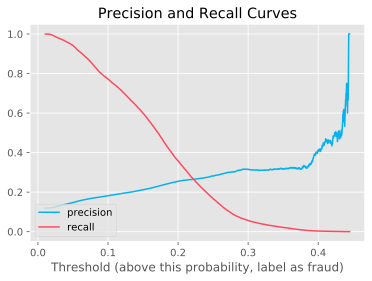

In [143]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test,log_reg.predict_proba(X_test_scaled)[:, 1])


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

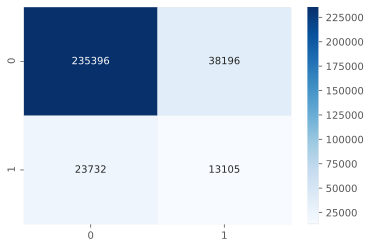

In [145]:
cm = confusion_matrix(y_test, y_test_pred_proba, labels = [0,1])
sns.heatmap(cm, annot=True,cmap = 'Blues', fmt='g')
plt.savefig('CM_heatmap.jpg')


In [155]:
# Decision Trees
for d in np.arange(45, 96, 10):
  decisiontree = DecisionTreeClassifier(max_depth = d)

  # replacing the missing temperature values by
  # the mean of the month coming from the train set
  X_tr = X_train.copy()
  X_ts = X_test.copy()

  ave = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].transform('mean')
  monthly_temp = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].mean()

  X_tr['LA_temp'] = X_tr['LA_temp'].fillna(ave)
  X_ts['LA_temp'] = X_ts.apply(vl_mean, axis = 1)

  decisiontree.fit(X_tr, y_train)
  y_train_pred = decisiontree.predict(X_tr)
  y_test_pred = decisiontree.predict(X_ts)

  print('Max depth: ', d)
  print('Training Set Metrics Results for RFC:')
  b_lr_accuracy_score = accuracy_score(y_train, y_train_pred)
  b_lr_recall_score=recall_score(y_train,y_train_pred)
  b_lr_precision_score=precision_score(y_train,y_train_pred)
  b_lr_f1_score=f1_score(y_train,y_train_pred)
  print(b_lr_accuracy_score, b_lr_recall_score, b_lr_precision_score, b_lr_f1_score)
  print('Testing Set Metrics Results (for predict) for RFC:')
  b_lr_ts_accuracy_score=accuracy_score(y_test,y_test_pred)
  b_lr_ts_recall_score=recall_score(y_test,y_test_pred)
  b_lr_ts_precision_score=precision_score(y_test,y_test_pred)
  b_lr_ts_f1_score=f1_score(y_test,y_test_pred)
  print(b_lr_ts_accuracy_score, b_lr_ts_recall_score, b_lr_ts_precision_score, b_lr_ts_f1_score)


Max depth:  45
Training Set Metrics Results for RFC:
0.9994753786937481 0.9959744973938943 0.9996029892573564 0.997785444542869
Testing Set Metrics Results (for predict) for RFC:
0.8050472088625741 0.2538208866085729 0.22061252418479543 0.2360544818793471
Max depth:  55
Training Set Metrics Results for RFC:
0.999792912642269 0.9982781087118392 0.9999766916066476 0.9991266782333283
Testing Set Metrics Results (for predict) for RFC:
0.8051953908945363 0.2559111762629964 0.22186396799246882 0.2376744361944861
Max depth:  65
Training Set Metrics Results for RFC:
0.999792912642269 0.9982781087118392 0.9999766916066476 0.9991266782333283
Testing Set Metrics Results (for predict) for RFC:
0.8048217144661098 0.2555039769796672 0.22106350995866217 0.2370392756853412
Max depth:  75
Training Set Metrics Results for RFC:
0.999792912642269 0.9982781087118392 0.9999766916066476 0.9991266782333283
Testing Set Metrics Results (for predict) for RFC:
0.8043062987027629 0.2545809919374542 0.2197900065622

Decision Trees are overfitting really badly. Looks like it is not able to increase recall and precision higher than 25 and 22 respectively

In [156]:
# Decision Trees
d = 120
decisiontree = DecisionTreeClassifier(max_depth = d)

# replacing the missing temperature values by
# the mean of the month coming from the train set
X_tr = X_train.copy()
X_ts = X_test.copy()

ave = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].transform('mean')
monthly_temp = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].mean()

X_tr['LA_temp'] = X_tr['LA_temp'].fillna(ave)
X_ts['LA_temp'] = X_ts.apply(vl_mean, axis = 1)

decisiontree.fit(X_tr, y_train)
y_train_pred = decisiontree.predict(X_tr)
y_test_pred = decisiontree.predict(X_ts)

print('Max depth: ', d)
print('Training Set Metrics Results for RFC:')
b_lr_accuracy_score = accuracy_score(y_train, y_train_pred)
b_lr_recall_score=recall_score(y_train,y_train_pred)
b_lr_precision_score=precision_score(y_train,y_train_pred)
b_lr_f1_score=f1_score(y_train,y_train_pred)
print(b_lr_accuracy_score, b_lr_recall_score, b_lr_precision_score, b_lr_f1_score)
print('Testing Set Metrics Results (for predict) for RFC:')
b_lr_ts_accuracy_score=accuracy_score(y_test,y_test_pred)
b_lr_ts_recall_score=recall_score(y_test,y_test_pred)
b_lr_ts_precision_score=precision_score(y_test,y_test_pred)
b_lr_ts_f1_score=f1_score(y_test,y_test_pred)
print(b_lr_ts_accuracy_score, b_lr_ts_recall_score, b_lr_ts_precision_score, b_lr_ts_f1_score)


Max depth:  120
Training Set Metrics Results for RFC:
0.999792912642269 0.9982781087118392 0.9999766916066476 0.9991266782333283
Testing Set Metrics Results (for predict) for RFC:
0.8055110830495862 0.25501533783967206 0.22194395879601192 0.23733309753293838


In [158]:
# Random Forests
trees = 145

randomforest = RandomForestClassifier(n_estimators=trees, max_depth = 60)

# replacing the missing temperature values by
# the mean of the month coming from the train set
X_tr = X_train.copy()
X_ts = X_test.copy()

ave = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].transform('mean')
monthly_temp = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].mean()

X_tr['LA_temp'] = X_tr['LA_temp'].fillna(ave)
X_ts['LA_temp'] = X_ts.apply(vl_mean, axis = 1)

randomforest.fit(X_tr, y_train)
y_train_pred = randomforest.predict(X_tr)
y_test_pred = randomforest.predict(X_ts)
print('n_estimator: ', trees)
print('Training Set Metrics Results for RFC:')
b_lr_accuracy_score = accuracy_score(y_train, y_train_pred)
b_lr_recall_score=recall_score(y_train,y_train_pred)
b_lr_precision_score=precision_score(y_train,y_train_pred)
b_lr_f1_score=f1_score(y_train,y_train_pred)
print(b_lr_accuracy_score, b_lr_recall_score, b_lr_precision_score, b_lr_f1_score)
print('Testing Set Metrics Results (for predict) for RFC:')
b_lr_ts_accuracy_score=accuracy_score(y_test,y_test_pred)
b_lr_ts_recall_score=recall_score(y_test,y_test_pred)
b_lr_ts_precision_score=precision_score(y_test,y_test_pred)
b_lr_ts_f1_score=f1_score(y_test,y_test_pred)
print(b_lr_ts_accuracy_score, b_lr_ts_recall_score, b_lr_ts_precision_score, b_lr_ts_f1_score)


n_estimator:  145
Training Set Metrics Results for RFC:
0.9997846291479597 0.9984758935219658 0.9997087808401091 0.9990919568330249
Testing Set Metrics Results (for predict) for RFC:
0.8863959230613119 0.06477183266824117 0.7453920649796938 0.11918677256606224


In [0]:
cm = confusion_matrix(y_test, y_test_pred, labels = [0,1])
sns.heatmap(cm, annot=True,cmap = 'Blues', fmt='g')
plt.savefig('CM_heatmap.jpg')

In all of the above models we can increase the precision, however, we end up with a very low recall. that is, in the above randomforest model only 70% of the predictions of 'arrest made' is actually correct, but only 6% of the 'arrest made' cases are predicted 

None of the abover models were oversampling or undersampling.

In the models using cross validation we will be oversampling our data to balance it out

I didn't run KNN or SVC since they were taking much longer time than the abover models

### Cross Validation

Logistic Regression with Cross Validation and oversampling the data

In [160]:
log_kf_stratified = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
log_val_f1_score_list = []
log_val_accuracy_list = []
log_val_recall_list = []
log_val_precision_list = []

log_tr_f1_score_list = []
log_tr_accuracy_list = []
log_tr_recall_list = []
log_tr_precision_list = []


threshold = 0.6
c = 0.01
for train_ind, val_index in log_kf_stratified.split(X_train, y_train):
  X_tr, X_vl = X_train.iloc[train_ind], X_train.iloc[val_index]
  y_tr, y_vl = y_train.iloc[train_ind], y_train.iloc[val_index]
  

  ave = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].transform('mean')
  monthly_temp = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].mean()

  X_tr['LA_temp'] = X_tr['LA_temp'].fillna(ave)
  X_vl['LA_temp'] = X_vl.apply(vl_mean, axis = 1)
  
  scaler = StandardScaler()
  X_tr_scaled = X_tr.copy()
  sc_columns_X_train = scaler.fit_transform(X_tr[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
      'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
      'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
      'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
      'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']])
  X_tr_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
      'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
      'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
      'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
      'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']] = sc_columns_X_train

  X_vl_scaled = X_vl.copy()
  sc_columns_X_test =  scaler.transform(X_vl[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
      'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
      'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
      'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
      'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']])
  X_vl_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
      'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
      'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
      'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
      'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']] = sc_columns_X_test
  
  
  ros = RandomOverSampler(random_state=1)
  X_resampled, y_resampled = ros.fit_sample(X_tr_scaled, y_tr)

  log_reg = LogisticRegression(solver= 'liblinear', C=10**i)
  log_reg.fit(X_resampled, y_resampled)

  train_predicted = (log_reg.predict_proba(X_tr_scaled)[:,1] >= threshold)
  val_predicted = (log_reg.predict_proba(X_vl_scaled)[:,1] >= threshold)
  

  log_tr_accuracy_list.append(accuracy_score(y_tr, train_predicted))
  log_tr_recall_list.append(recall_score(y_tr, train_predicted))
  log_tr_precision_list.append(precision_score(y_tr, train_predicted))
  log_tr_f1_score_list.append(f1_score(y_tr, train_predicted))
  
  log_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
  log_val_recall_list.append(recall_score(y_vl, val_predicted))
  log_val_precision_list.append(precision_score(y_vl, val_predicted))
  log_val_f1_score_list.append(f1_score(y_vl, val_predicted))


print('C: = ', c)
log_tr_mean_accuracy = sum(log_tr_accuracy_list)/len(log_tr_accuracy_list)
log_tr_mean_precision = sum(log_tr_precision_list)/len(log_tr_precision_list)
log_tr_mean_recall = sum(log_tr_recall_list)/len(log_tr_recall_list)
log_tr_mean_f1 = sum(log_tr_f1_score_list)/len(log_tr_f1_score_list)

log_vl_mean_accuracy = sum(log_val_accuracy_list)/len(log_val_accuracy_list)
log_vl_mean_precision = sum(log_val_precision_list)/len(log_val_precision_list)
log_vl_mean_recall = sum(log_val_recall_list)/len(log_val_recall_list)
log_vl_mean_f1 = sum(log_val_f1_score_list)/len(log_val_f1_score_list)
print(log_tr_mean_accuracy,log_vl_mean_accuracy)
print(log_tr_mean_precision,log_vl_mean_precision)
print(log_tr_mean_recall,log_vl_mean_recall)
print(log_tr_mean_f1,log_vl_mean_f1)

  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipyker

C: =  0.01
0.7393767634921309 0.7389995219044495
0.23165501740344233 0.23097359232188036
0.516366700661247 0.5149036572940594
0.3198267240167757 0.31889603172774433


In [167]:

X_test['LA_temp'] = X_test.apply(vl_mean, axis = 1)

X_ts_scaled = X_test.copy()

sc_columns_X_test =  scaler.transform(X_test[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
    'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
    'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
    'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
    'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']])
X_ts_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
    'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
    'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
    'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
    'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']] = sc_columns_X_test

ts_predicted = (log_reg.predict_proba(X_ts_scaled)[:,1] >= threshold)

log_trs_accuracy_list = accuracy_score(y_test, ts_predicted)
log_ts_recall = recall_score(y_test, ts_predicted)
log_ts_precision=precision_score(y_test, ts_predicted)
log_ts_f1_score=f1_score(y_test, ts_predicted)

print('Test Scores for CV Log Regression:')
print(log_trs_accuracy_list)
print(log_ts_recall)
print(log_ts_precision)
print(log_ts_f1_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Test Scores for CV Log Regression:
0.7387518563020852
0.5119852322393246
0.23005049889000023
0.31745764566273066


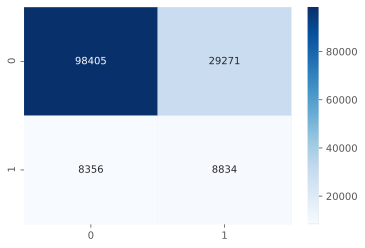

In [161]:
cm = confusion_matrix(y_vl, val_predicted, labels = [0,1])
sns.heatmap(cm, annot=True,cmap = 'Blues', fmt='g')
plt.savefig('CM_heatmap.jpg')


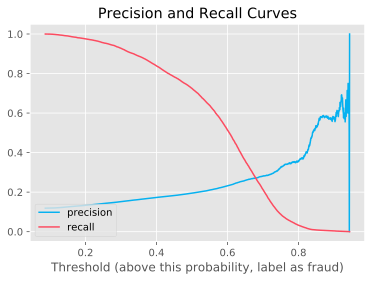

In [164]:

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_vl,log_reg.predict_proba(X_vl_scaled)[:, 1])


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

Decision Trees with Cross Validation and oversampling the data 

In [170]:
dt_kf_stratified = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
dt_val_f1_score_list = []
dt_val_accuracy_list = []
dt_val_recall_list = []
dt_val_precision_list = []

dt_tr_f1_score_list = []
dt_tr_accuracy_list = []
dt_tr_recall_list = []
dt_tr_precision_list = []


max_d = 60
threshold = 0.6
new_X_train = X_train
for train_ind, val_index in dt_kf_stratified.split(X_train, y_train):
  X_tr, X_vl = new_X_train.iloc[train_ind], new_X_train.iloc[val_index]
  y_tr, y_vl = y_train.iloc[train_ind], y_train.iloc[val_index]
  
  ave = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].transform('mean')
  monthly_temp = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].mean()

  X_tr['LA_temp'] = X_tr['LA_temp'].fillna(ave)
  X_vl['LA_temp'] = X_vl.apply(vl_mean, axis = 1)

  ros = RandomOverSampler(random_state=1)
  X_resampled, y_resampled = ros.fit_sample(X_tr, y_tr)

  dt_model = DecisionTreeClassifier(max_depth=max_d)
  dt_model.fit(X_resampled, y_resampled)
  train_predicted = (dt_model.predict_proba(X_tr)[:, 1] >= threshold)
  
  val_predicted = (dt_model.predict_proba(X_vl)[:, 1] >= threshold)
    
  dt_tr_accuracy_list.append(accuracy_score(y_tr, train_predicted))
  dt_tr_recall_list.append(recall_score(y_tr, train_predicted))
  dt_tr_precision_list.append(precision_score(y_tr, train_predicted))
  dt_tr_f1_score_list.append(f1_score(y_tr, train_predicted))
  
  dt_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
  dt_val_recall_list.append(recall_score(y_vl, val_predicted))
  dt_val_precision_list.append(precision_score(y_vl, val_predicted))
  dt_val_f1_score_list.append(f1_score(y_vl, val_predicted))


print('Tree Depth: max_d = ', max_d)
dt_tr_mean_accuracy = sum(dt_tr_accuracy_list)/len(dt_tr_accuracy_list)
dt_tr_mean_precision = sum(dt_tr_precision_list)/len(dt_tr_precision_list)
dt_tr_mean_recall = sum(dt_tr_recall_list)/len(dt_tr_recall_list)
dt_tr_mean_f1 = sum(dt_tr_f1_score_list)/len(dt_tr_f1_score_list)

dt_vl_mean_accuracy = sum(dt_val_accuracy_list)/len(dt_val_accuracy_list)
dt_vl_mean_precision = sum(dt_val_precision_list)/len(dt_val_precision_list)
dt_vl_mean_recall = sum(dt_val_recall_list)/len(dt_val_recall_list)
dt_vl_mean_f1 = sum(dt_val_f1_score_list)/len(dt_val_f1_score_list)
print(dt_tr_mean_accuracy,dt_vl_mean_accuracy)
print(dt_tr_mean_precision,dt_vl_mean_precision)
print(dt_tr_mean_recall,dt_vl_mean_recall)
print(dt_tr_mean_f1,dt_vl_mean_f1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipyker

Tree Depth: max_d =  60
0.9998239757530761 0.8145836454660875
0.9985246294731696 0.22183491685531168
0.9999941828335418 0.22429964892611087
0.9992588591279155 0.22306003420443438


In [174]:

X_test['LA_temp'] = X_test.apply(vl_mean, axis = 1)

X_ts_scaled = X_test.copy()

sc_columns_X_test =  scaler.transform(X_test[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
    'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
    'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
    'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
    'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']])
X_ts_scaled[['Victim Age','White_pop', 'Black_pop', 'Ameri_es_pop', 
    'Asian_pop', 'Hawn_pi_pop','Hispanic_pop', 'Other_pop',
    'Multi_pop', 'Median_age', 'LA_temp','Med_age_male',
    'Med_age_female', 'Avg_hh_size', 'Vacant', 'Owner_occ', 
    'Renter_occ','Pop2010', 'Male_pop', 'Female_pop']] = sc_columns_X_test

ts_predicted = (dt_model.predict_proba(X_ts_scaled)[:,1] >= threshold)

dt_accuracy_list = accuracy_score(y_test, ts_predicted)
dt_ts_recall = recall_score(y_test, ts_predicted)
dt_ts_precision=precision_score(y_test, ts_predicted)
dt_ts_f1_score=f1_score(y_test, ts_predicted)

print('Test Scores for CV Decision Tree:')
print(dt_accuracy_list)
print(dt_ts_recall)
print(dt_ts_precision)
print(dt_ts_f1_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Test Scores for CV Decision Tree:
0.8307954475902702
0.09026250780465293
0.148842830923497
0.11237663917804516


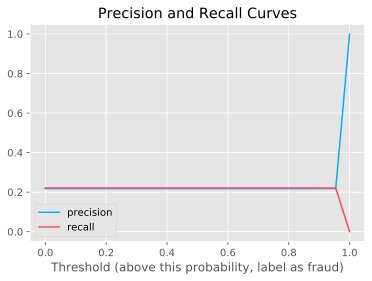

In [172]:

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_vl,dt_model.predict_proba(X_vl)[:, 1] )


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

Random Forest with Cross Validation and oversampling the data

In [177]:
rf_kf_stratified = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []


threshold = 0.7
for train_ind, val_index in rf_kf_stratified.split(X_train, y_train):
  X_tr, X_vl = X_train.iloc[train_ind], X_train.iloc[val_index]
  y_tr, y_vl = y_train.iloc[train_ind], y_train.iloc[val_index]

  ave = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].transform('mean')
  monthly_temp = X_tr[['Month_of_Reported', 'LA_temp']].groupby(['Month_of_Reported'])['LA_temp'].mean()

  X_tr['LA_temp'] = X_tr['LA_temp'].fillna(ave)
  X_vl['LA_temp'] = X_vl.apply(vl_mean, axis = 1)

  ros = RandomOverSampler(random_state=1)
  X_resampled, y_resampled = ros.fit_sample(X_tr, y_tr)

  rf_model = RandomForestClassifier(n_estimators = 45, max_depth = 11)
  rf_model.fit(X_resampled, y_resampled)
  train_predicted = (rf_model.predict_proba(X_tr)[:, 1] >= threshold)
  
  val_predicted = (rf_model.predict_proba(X_vl)[:, 1] >= threshold)
  
  rf_tr_accuracy_list.append(accuracy_score(y_tr, train_predicted))
  rf_tr_recall_list.append(recall_score(y_tr, train_predicted))
  rf_tr_precision_list.append(precision_score(y_tr, train_predicted))
  rf_tr_f1_score_list.append(f1_score(y_tr, train_predicted))
  
  rf_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
  rf_val_recall_list.append(recall_score(y_vl, val_predicted))
  rf_val_precision_list.append(precision_score(y_vl, val_predicted))
  rf_val_f1_score_list.append(f1_score(y_vl, val_predicted))


rf_tr_mean_accuracy = sum(rf_tr_accuracy_list)/len(rf_tr_accuracy_list)
rf_tr_mean_precision = sum(rf_tr_precision_list)/len(rf_tr_precision_list)
rf_tr_mean_recall = sum(rf_tr_recall_list)/len(rf_tr_recall_list)
rf_tr_mean_f1 = sum(rf_tr_f1_score_list)/len(rf_tr_f1_score_list)

rf_vl_mean_accuracy = sum(rf_val_accuracy_list)/len(rf_val_accuracy_list)
rf_vl_mean_precision = sum(rf_val_precision_list)/len(rf_val_precision_list)
rf_vl_mean_recall = sum(rf_val_recall_list)/len(rf_val_recall_list)
rf_vl_mean_f1 = sum(rf_val_f1_score_list)/len(rf_val_f1_score_list)
print('Train             Validation')
print(rf_tr_mean_accuracy,rf_vl_mean_accuracy)
print(rf_tr_mean_precision,rf_vl_mean_precision)
print(rf_tr_mean_recall,rf_vl_mean_recall)
print(rf_tr_mean_f1,rf_vl_mean_f1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipyker

Train             Validation
0.8763681567965464 0.8708879364325414
0.43073045613775074 0.3467960579911472
0.1278620586191374 0.0991600594342136
0.1970190853183161 0.15410533556416728


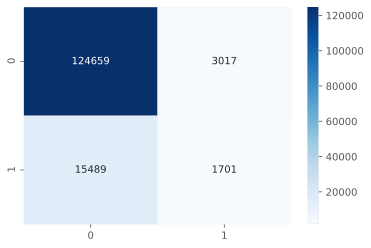

In [178]:
cm = confusion_matrix(y_vl, val_predicted, labels = [0,1])
sns.heatmap(cm, annot=True,cmap = 'Blues', fmt='g')
plt.savefig('CM_heatmap.jpg')


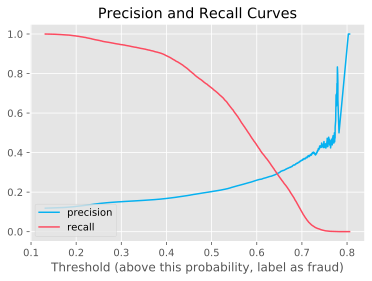

In [179]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_vl,rf_model.predict_proba(X_vl)[:, 1] )


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [180]:
X_train.shape

(724332, 58)

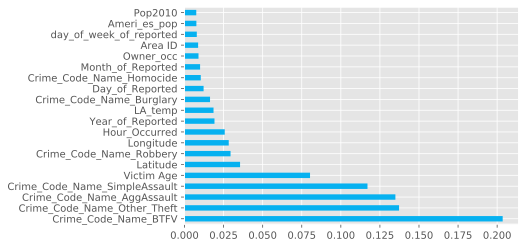

In [182]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')


In [183]:
sorted(feat_importances)

[6.820208929891109e-05,
 7.15927118848514e-05,
 0.0001829626948062979,
 0.0002119145682758041,
 0.00022815589088618504,
 0.0002345642824140221,
 0.00024380864216908208,
 0.00024987656646373465,
 0.0002899703466224381,
 0.00029059269536971244,
 0.0002989258247883174,
 0.0004505716744391929,
 0.0005375380670290459,
 0.0005472963475446346,
 0.0005948847890467535,
 0.0006068149883441083,
 0.0006742825154605546,
 0.0009416026301049818,
 0.0010207280399810999,
 0.00145371266050525,
 0.001458273891404808,
 0.001499214038325341,
 0.0017442337119307173,
 0.0024687265080419484,
 0.0030800319915261767,
 0.0031328053289542412,
 0.0033487597107240584,
 0.0035721985240524026,
 0.0038650290737932097,
 0.003990316979447825,
 0.0040090696746208875,
 0.004323133992796358,
 0.004644996419765243,
 0.00547474949903766,
 0.005737278763870314,
 0.005742032008022136,
 0.005892844346179789,
 0.007247005459679566,
 0.007536000171743024,
 0.007610124214779303,
 0.007878841955110969,
 0.008728311764722996,
 0.008